## <center>Elements Of Data Science - F2020</center>
# <center>Week 9: Dimensionality Reduction, Feature Selection and Feature Extraction<center>
### <center>11/16/2020</center>

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

sns.set_style('darkgrid')
%matplotlib inline

# TODOs

- Readings:
  - PML Chapter 6, first 3 sections on Pipelines
  - PML Chapter 8
<br>
<br>

- HW3, Out this week
<br>

- Answer and submit Quiz 9, **Sunday Nov 22nd, 11:59pm ET**

# Today

- **Joining Datasets**
- **Dimensionality Reduction**
  - **Feature Selection**
     - LASSO
     - Tree Based Models Feature Importance
     - Univariate Tests
     - Recursive Feature Selection
  - **Feature Extraction**
     - PCA
- **Image Recognition Using PCA**
 

<br>
<br>

# <center>Questions?</center>
<br>
<br>

# Simple Joins: Sharing An Index

In [2]:
df1 = pd.DataFrame({'A': ['A0','A1','A2']})
df1

,A
0,A0
1,A1
2,A2


In [3]:
df2 = pd.DataFrame({'B': ['B0','B1','B2']})
df2

,B
0,B0
1,B1
2,B2


In [4]:
df1.join(df2)

,A,B
0,A0,B0
1,A1,B1
2,A2,B2


# Simple Joins: Left Join
<br>

<div align="center"><img src="images/join_left.png" width="300px"></div>

In [5]:
df3 = pd.DataFrame({'C': ['C1','C2','C3']},index=[1,2,3])
df3

,C
1,C1
2,C2
3,C3


In [6]:
df1.join(df3,how="left") # default is left join

,A,C
0,A0,NaN
1,A1,C1
2,A2,C2


# Simple Joins: Right Join
<br>

<div align="center"><img src="images/join_right.png" width="300px"></div>

In [7]:
df1.join(df3,how="right")

,A,C
1,A1,C1
2,A2,C2
3,NaN,C3


# Simple Joins: Inner Join
<br>

<div align="center"><img src="images/join_inner.png" width="300px"></div>

In [8]:
df1.join(df3,how="inner")

,A,C
1,A1,C1
2,A2,C2


# Simple Joins: Outer Join
<br>

<div align="center"><img src="images/join_outer.png" width="300px"></div>

In [9]:
df1.join(df3,how="outer")

,A,C
0,A0,NaN
1,A1,C1
2,A2,C2
3,NaN,C3


<br>
<br>

# <center>Dimensionality Reduction</center>
<br>
<br>

# Avoiding Overfitting
<br>

- Collect additional examples
- Use a simpler model
- Regularization
- Reduce the dimensions of our data: Dimensionality Reduction

# Dimensionality Reduction
<br>

- Reasons to reduce the number of features
 - improve model performance (reducing complexity reducing chance of overfitting)
 - improve speed performance (reducing number of calculations)
 - interpretation (which features are most important?)
<br>
<br>

- **Feature Selection**
 - choose a subset of original features
<br>
<br>
- **Feature Extraction**
 - combine features to generate a new feature space

# Load Binary Wine Classification

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

wine = datasets.load_wine()

X_wine = pd.DataFrame(wine.data,columns=wine.feature_names)
y_wine = wine.target

X_wine = X_wine.iloc[y_wine < 2]
y_wine = y_wine[y_wine < 2]

feature_names = X_wine.columns.values

X_train,X_test,y_train,y_test = train_test_split(X_wine,y_wine,random_state=0)

X_train = pd.DataFrame(X_train,columns=X_wine.columns)

feature_names

array(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'], dtype=object)

# Standardize Features

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)

X_test = ss.transform(X_test)

In [12]:
X_train.agg(['mean','std']).round(1).T.head()

,mean,std
alcohol,0.0,1.0
malic_acid,-0.0,1.0
ash,-0.0,1.0
alcalinity_of_ash,0.0,1.0
magnesium,0.0,1.0


# Aside: Predicting vs Transforming with Train/Test Split
<br>
- When transforming data, fit on the training set, transform both train and test
<br>
<br>

<div align="center"><img src="images/transformation_pipeline.png" width="900px"></div>

From PML

# Aside: Predicting vs Transforming with Train/Test Split
<br>
- When performing prediction, train on the training set, evaluate on the test set
<br>

<div align="center"><img src="images/modelpredict_pipeline.png" width="500px"></div>

From PML

# Feature Selection: LASSO (L1)

In [13]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(C=100, penalty="l1", solver="liblinear", random_state=123)
logr.fit(X_train, y_train)

logr.coef_

array([[-5.74709641, -1.20824931, -2.70057811,  2.47398434, -0.28304842,
        -0.14584941, -0.37559551,  0.        ,  1.14394581, -0.63815798,
         1.06926936, -0.86036347, -7.567675  ]])

In [14]:
logr = LogisticRegression(C=0.1, penalty="l1", solver="liblinear", random_state=123)
logr.fit(X_train, y_train)
logr.coef_

array([[-0.98231183,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.00652705,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.10166563]])

In [15]:
feature_names[logr.coef_[0] != 0]

array(['alcohol', 'flavanoids', 'proline'], dtype=object)

# Feature Selection: Tree Based Model Feature Importance

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=123).fit(X_train,y_train)
rf.feature_importances_ # (normalized) total reduction of function measuring impurity

array([0.27332426, 0.01783127, 0.01145411, 0.05480187, 0.05158374,
       0.05521824, 0.10260545, 0.01117794, 0.01033494, 0.13339066,
       0.00759636, 0.0216486 , 0.24903258])

In [17]:
feature_importances = pd.Series(rf.feature_importances_,index=feature_names)
feature_importances.sort_values(ascending=False).round(3)

alcohol                         0.273
proline                         0.249
color_intensity                 0.133
flavanoids                      0.103
total_phenols                   0.055
alcalinity_of_ash               0.055
magnesium                       0.052
od280/od315_of_diluted_wines    0.022
malic_acid                      0.018
ash                             0.011
nonflavanoid_phenols            0.011
proanthocyanins                 0.010
hue                             0.008
dtype: float64

# Feature Selection: Tree Based Model Feature Importance

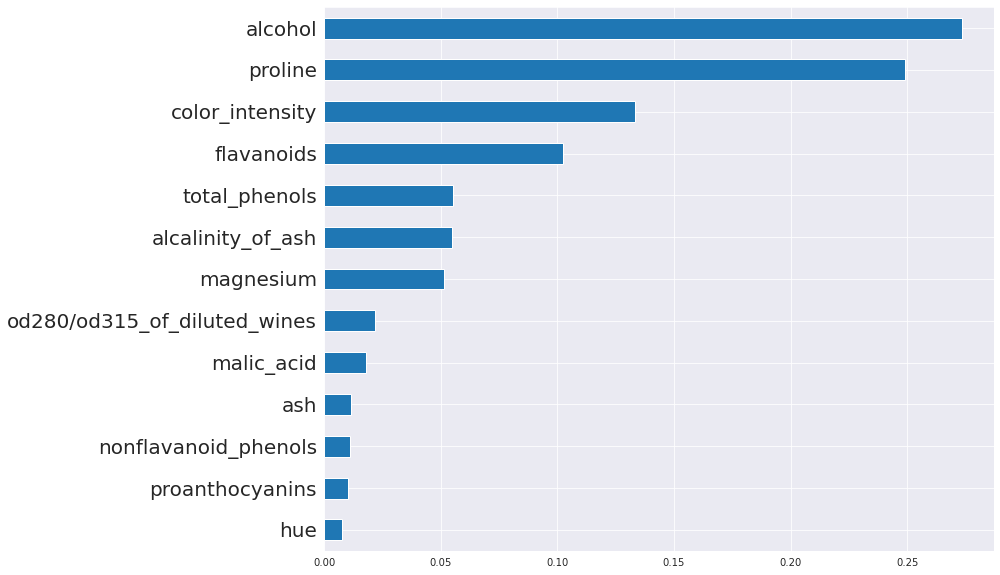

In [18]:
fig,ax = plt.subplots(1,1,figsize=(12,10))
feature_importances.sort_values().plot.barh(ax=ax);
ax.set_yticklabels(ax.get_yticklabels(),fontsize=20);

# Feature Selection: SelectFromModel

In [19]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(logr,
                      threshold=None, # if model uses l1 regularization, anythin greater than 1e-5
                      prefit=True     # do not need to re-fit
                     )

sfm.get_support()

array([ True, False, False, False, False, False,  True, False, False,
       False, False, False,  True])

In [20]:
feature_names[sfm.get_support()]

array(['alcohol', 'flavanoids', 'proline'], dtype=object)

In [21]:
X_train_subset = sfm.transform(X_train)
X_train_subset.shape

(97, 3)

In [22]:
sfm_rf = SelectFromModel(RandomForestClassifier(),
                         threshold='mean',   # return all features with value greater than the mean
                         prefit=False        # need to refit
                        ).fit(X_train,y_train)
feature_names[sfm_rf.get_support()]

array(['alcohol', 'flavanoids', 'color_intensity', 'proline'],
      dtype=object)

# Feature Selection: Univariate Tests

- Perform statistical test on each feature independent of all others
  - Rank and select top k features
  - sklearn: SelectKBest
  - requires a scoring function
<br>
<br>

- Example: `f_classif`
  - F-test
  - estimates the degree of linear dependency between feature x and target y

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

# select 2 best features
kbest = SelectKBest(score_func=f_classif, # default,
                    k=3                   # how many features to keep
                   ).fit(X_train, y_train)
list(X_wine.columns[kbest.get_support()])

['alcohol', 'color_intensity', 'proline']

# Feature Selection: Recursive Feature Elimination

- Would like to test all possible combinations of features
- Likely prohibitively expensive/time-consuming
- Instead recursively select smaller subsets of features
- Requires a model that assigns weights or importance to features

In [24]:
from sklearn.feature_selection import RFE

rfe = RFE(LogisticRegression(penalty='none'), # turn of regularization
          n_features_to_select=3,             # number of feature to retain
          step=1                              # number of features to eliminate each round
         ).fit(X_train,y_train)

feature_names[rfe.get_support()]

array(['alcohol', 'alcalinity_of_ash', 'proline'], dtype=object)

# Feature Selection: Other Methods

- by **Variance**
 - eliminate columns where all rows have the same (or almost all the same) value
- **Sequential Feature Selection**
 - greedy algorithm similar to Recursive Feature Elimination
 - uses performance metric (eg accuracy) instead of weights, importances
 - via `mlxtend`
- **Exaustive Feature Selection**
 - evaluate all possible feature combinations
 - uses performance metric (eg accuracy) instead of weights, importances
 - via `mlxtend`
- Other **Univariate tests**
 - `f_regression`, F-test for regression task
 - `mutual_info_classif` and `_regression`
 - `chi2`, for classification, requires non-negative values



# Feature Extraction

- Transform original features into new feature space
- Can be thought of as compression while maintaining relevant information
- Often used for:
 - visualization (multi-dimensional to 2-D)
 - compression (storage)
 - dimensionality reduction
 
- Popular methods:
 - **Principal Component Analysis:** Unsupervised data compression
 - Linear Discriminant Analysis: Supervised method to maximize class separation
 - Kernel PCA, etc.

# Principal Component Analysis (PCA)

- Unsupervised Learning method (ignores label)
- Idea: 
 - Directions of high variance in the data contain important information
 - Colinear features can be combined
 - Find directions of maximum variance
 - Project onto subspace with same or fewer dimensions
<br>

# Principal Component Analysis (PCA)
<br>

- How it works:
  0. first center the data (subtract the means)
  1. first component:
    - direction (combination of features)
    - explains maximum variance
  2. next component:
    - direction, orthogonal to the first (linearly independent)
    - explains max remaining variance
  3. repeat:
    - max number of possible components equals number of original dimensions

In [25]:
# function to plot a vector
def draw_vector(v0,v1,ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(width=3,
                    headwidth=12,
                    shrink=0,
                    color='k'
                    #arrowstyle='->',
                    #linewidth=6,
                    #shrinkA=0,shrinkB=0
                   )
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data, pca vectors and pca planes
def plot_pca(df,pca,num_components=1,colors=['r','g'],fig=None):
    fig = fig or plt.figure(figsize=(14,6))
    plt.subplot2grid((2,2), (0, 0), rowspan=2)
    sns.scatterplot(x=df.columns[0],y=df.columns[1],data=df);
    plt.scatter(1,2,c='k',linewidths=5)

    for i in range(num_components):
        length = pca.explained_variance_[i]
        vector = pca.components_[i]
        slope0 = vector[1] / vector[0]
        _= plt.plot([-3,3],[slope0*-3,slope0*3],color=colors[i])
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_,pca.mean_ + v)
    plt.gca().set_aspect('equal')
    #plt.axis([-8.5, 8.5, -8.5, 8.5])
    X = pca.transform(df)
    for i in range(num_components):
        plt.subplot2grid((2,2), (i, 1))
        plt.plot([-4,4],[0,0],colors[i])
        sns.scatterplot(x=X[:,i],y=[0]*len(X));
        plt.scatter(pca.transform([[1,2]])[0][i],0,color='k',linewidths=5)
        plt.axis([-4.5, 4.5, -1, 1]);
        plt.xlabel('component '+str(i))

# PCA Example

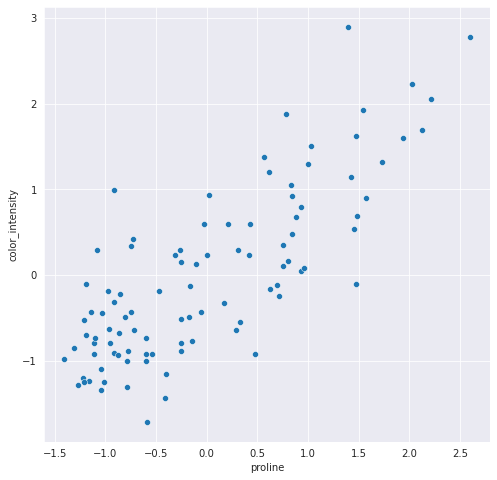

In [26]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(x='proline',y='color_intensity',data=X_train,ax=ax);

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_train[['proline','color_intensity']])

# PCA Example Cont.

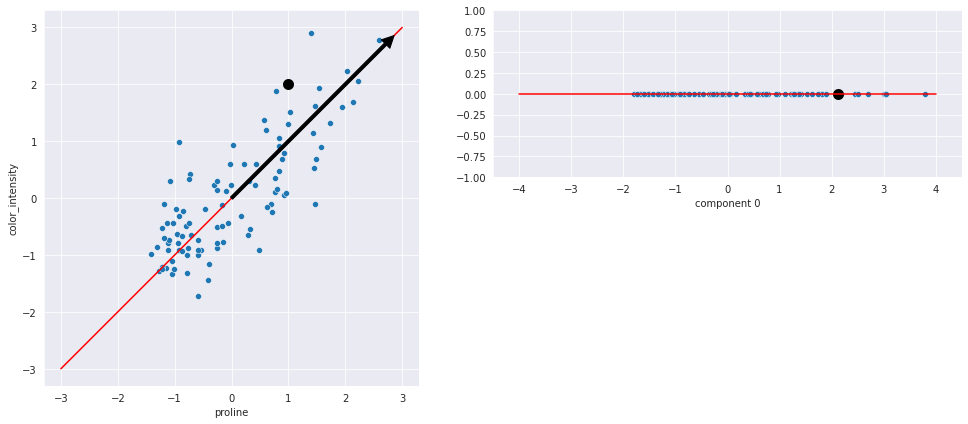

In [28]:
plot_pca(X_train[['proline','color_intensity']],pca,num_components=1)
plt.tight_layout()

# PCA Example Cont.

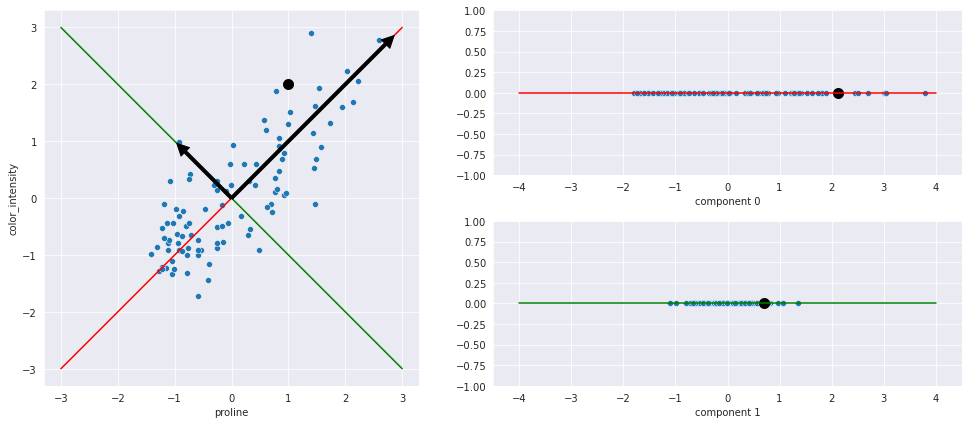

In [29]:
plot_pca(X_train[['proline','color_intensity']],pca,num_components=2)
plt.tight_layout()

# PCA in sklearn

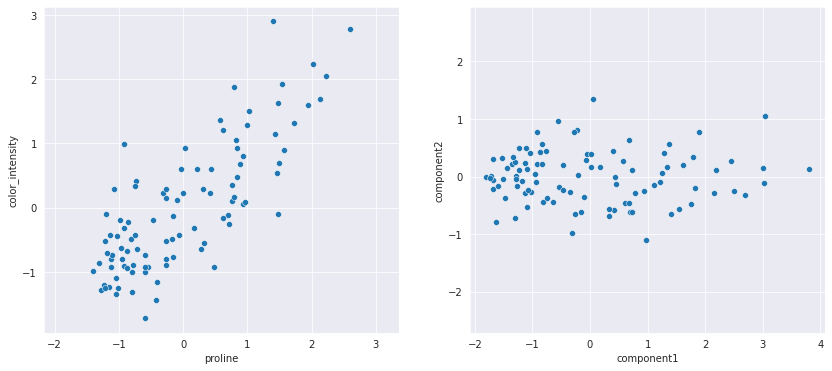

In [30]:
from sklearn.decomposition import PCA

# extract the first 2 principle compenents
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train[['proline','color_intensity']])

X_pca = pd.DataFrame(X_pca,columns=['component1','component2'])


fig,ax=plt.subplots(1,2,figsize=(14,6))
sns.scatterplot(x='proline',y='color_intensity',data=X_train,ax=ax[0]);
sns.scatterplot(x='component1',y='component2',data=X_pca,ax=ax[1]);
ax[0].axis('equal');ax[1].axis('equal');

# PCA: Explained Variance
<br>

- How much of the variance is explained by each component?

In [31]:
pca.explained_variance_ratio_

array([0.89808764, 0.10191236])

# PCA: Principle Components
<br>

- What does the first component (vector) look like?

In [32]:
pca.components_[0]

array([0.70710678, 0.70710678])

- And the second?

In [33]:
pca.components_[1]

array([-0.70710678,  0.70710678])

# Dimensionality Reduction with PCA

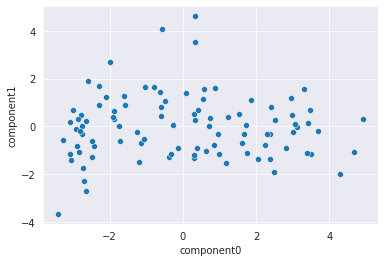

In [34]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_train,y_train)
X_2d = pd.DataFrame(X_2d, columns=["component"+str(i) for i in range(2)])
sns.scatterplot(x='component0',y='component1',data=X_2d);

In [35]:
print(' + \n'.join([f'{w: 0.2f}*{f}' for f,w in sorted(zip(X_train.columns,pca_2d.components_[0]),key=lambda x:x[1])]))

-0.28*nonflavanoid_phenols + 
-0.26*alcalinity_of_ash + 
-0.03*hue + 
 0.01*malic_acid + 
 0.11*ash + 
 0.21*proanthocyanins + 
 0.23*magnesium + 
 0.25*od280/od315_of_diluted_wines + 
 0.36*proline + 
 0.36*color_intensity + 
 0.36*total_phenols + 
 0.37*alcohol + 
 0.39*flavanoids


<br>
<br>

# <center>Image Recognition Example</center>
<br>
<br>

# PCA and Image Recognition

- Generally, image is represented by a grid of pixels
- Each pixel is a square that takes a value representing a shade (usually a value between 0 and 255)
- 1024 x 1024 pixels = 1,048,576 pixels = 1 megapixel
- iPhone X11 Pro : 12 megapixels
- Color images contain three layers: red, green, blue
- ~36 million pixel values
- A very high dimensional space!
<br>

- Image classification using PCA?
 - Example based on [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)


# Example Dataset: LFW
<br>

[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)

In [36]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

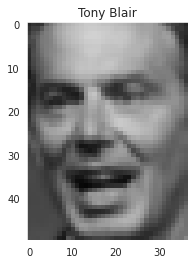

In [37]:
sns.set_style('dark')
plt.imshow(lfw_people.images[1], cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title(lfw_people.target_names[lfw_people.target[1]], size=12);

# Example Pixel Values

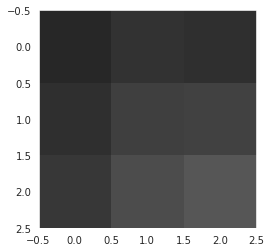

In [38]:
# first 3x3 set of pixels
plt.imshow(lfw_people.images[1][:3,:3],cmap=plt.cm.gray,vmin=0, vmax=255);

In [39]:
lfw_people.images[1][:3,:3]

array([[39.666668, 50.333332, 47.      ],
       [47.666668, 63.      , 65.333336],
       [55.333332, 76.666664, 86.333336]], dtype=float32)

# Representing each Image: Flatten
<br>

- Grid as a fixed length feature vector?

In [40]:
lfw_people.images[1].shape

(50, 37)

In [41]:
x = lfw_people.images[1].reshape(1,-1)
x

array([[ 39.666668,  50.333332,  47.      , ..., 117.666664, 115.      ,
        133.66667 ]], dtype=float32)

In [42]:
x.shape

(1, 1850)

What information do we lose when we do this?

# Create a Dataset

In [43]:
# get the shape of images for plotting the
n_samples, h, w = lfw_people.images.shape

# use actual pixel values, ignoring relative position
X_faces = lfw_people.data
n_features = X_faces.shape[1]

# the label to predict is the id of the person
y_faces = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# create train/test split
X_train_faces, X_test_faces, y_train_faces, y_test_faces = train_test_split(X_faces, y_faces,
                                                                            test_size=0.25,
                                                                            stratify=y_faces,
                                                                            random_state=123)
print(f"image_size: {h}x{w}")
print("n_features: %d" % n_features)
print("n_classes : %d" % n_classes)
print(f"n_train   : {len(X_train_faces)}")
print(f"n_test    : {len(X_test_faces)}")

image_size: 50x37
n_features: 1850
n_classes : 7
n_train   : 966
n_test    : 322


# Compute PCA and Transform

In [44]:
# set the number of dimensions we want to retain
n_components = 150

# instantiate and fit on X_train
pca_faces = PCA(n_components=n_components,
                svd_solver='randomized',
                whiten=True).fit(X_train_faces)

# extract and reshape components into eigenfaces for plotting
eigenfaces = pca_faces.components_.reshape((n_components, h, w))

# transform the training and test set for classification
X_train_pca_faces = pca_faces.transform(X_train_faces)
X_test_pca_faces = pca_faces.transform(X_test_faces)

# Eigenfaces

- What if we plot the top 12 components (eigenfaces) using .reshape(h,w)?

In [45]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

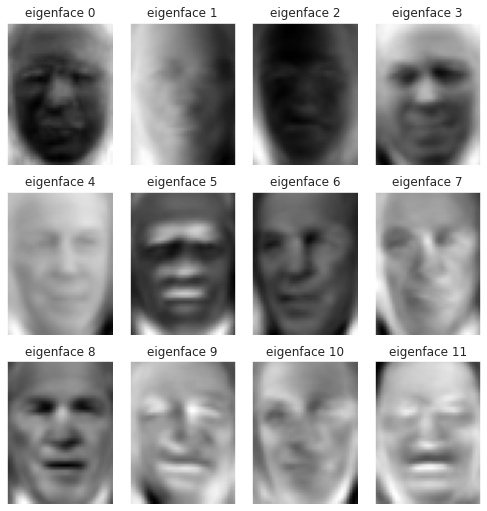

In [46]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.tight_layout()

# Train and Tune SVC

In [47]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

params = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf_faces = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                         params, cv=3, n_jobs=-1)
clf_faces = clf_faces.fit(X_train_pca_faces, y_train_faces)

CPU times: user 475 ms, sys: 123 ms, total: 599 ms
Wall time: 6.14 s


In [48]:
print(f"best_params : {clf_faces.best_params_}")
print(f"best_score  : {clf_faces.best_score_:0.2f}")

best_params : {'C': 1000.0, 'gamma': 0.001}
best_score  : 0.79


# Evaluate on the test set

In [49]:
y_pred = clf_faces.predict(X_test_pca_faces)
from sklearn.metrics import classification_report
print(classification_report(y_test_faces, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.74      0.72        19
     Colin Powell       0.77      0.86      0.82        59
  Donald Rumsfeld       0.83      0.83      0.83        30
    George W Bush       0.87      0.89      0.88       133
Gerhard Schroeder       0.81      0.48      0.60        27
      Hugo Chavez       0.92      0.67      0.77        18
       Tony Blair       0.78      0.86      0.82        36

         accuracy                           0.82       322
        macro avg       0.81      0.76      0.78       322
     weighted avg       0.83      0.82      0.82       322



# Prediction Examples

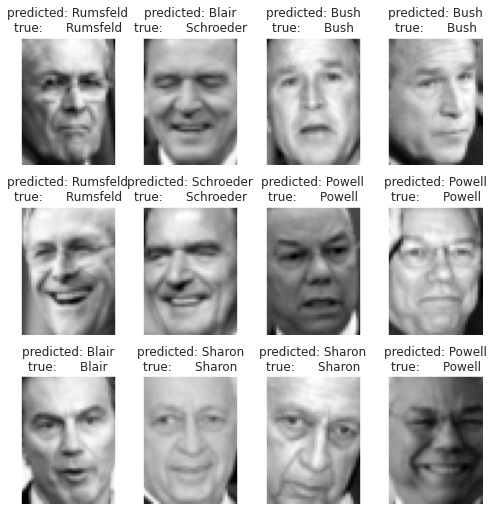

In [50]:
prediction_titles = [title(y_pred, y_test_faces, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test_faces, prediction_titles, h, w)
plt.tight_layout()

# Performance without PCA

# Other Image Recognition Methods

- With Feature Engineering and general models
 - ex: Histogram of Oriented Gradients or HOG (See PDSH Chap 5)
 - many more (See [scikit-image](https://scikit-image.org/))
<br>
<br>

<div align="center"><img src="images/cat_hog.png" width="1600px"></div>
    
<font size=3>From PDSH</font>

# Other Image Recognition Methods: Deep Neural Networks
<br>

- With Deep Neural Nets
<br>

<div align="center"><img src="images/dnn_image_recognition.png" width="800px"></div>
<br>
<br>

<font size=4>From https://www.researchgate.net/figure/Layers-and-their-abstraction-in-deep-learning-Image-recognition-as-measured-by-ImageNet_fig17_326531654</font>

# Other Image Recognition Methods: Deep Neural Networks
<br>

- With Convolutional Neural Networks [Good Example](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)
<br>
<br>

<div align="center"><img src="images/cnn.jpeg" width="1200px"></div>
<br>
<br>

<font size=3>From https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53</font>

<br>
<br>

# <center>Questions?</center>
<br>
<br>